In [ ]:
!pip install timm ttach

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 509 kB 5.1 MB/s 


In [ ]:
!unzip /content/drive/MyDrive/emotion.zip

In [ ]:
from glob import glob
import time
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os 
from tqdm import tqdm
import shutil
import collections
from PIL import Image

from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from torchvision.models import vgg19_bn, VGG19_BN_Weights
import torch
from torch import nn, optim
from tqdm import tqdm
import torch.nn.functional as F
import timm
import ttach as tta 

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
os.makedirs('save_models/', exist_ok=True)

num2class = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'neutral',
    5: 'sad',
    6: 'surprise',
}
class2num = {k: v for v, k in num2class.items()}
class2num

batch_size = 128
n_classes = 7
lr = 5e-5
weight_decay = 1e-3
epochs = 10

mean = torch.tensor(0.5, dtype=torch.float32)
std = torch.tensor(0.5, dtype=torch.float32)
normalize = transforms.Normalize(mean.tolist(), std.tolist())
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

In [ ]:
def image_to_tensor(image):
    transform = transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.Grayscale(1),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5),
    ])
    return transform(image)

def split_dataset(label):
    train_dir = f'./train_augmented/{label}'
    valid_dir = f'./valid_augmented/{label}'
    
    if not os.path.exists(train_dir): os.makedirs(train_dir)
    if not os.path.exists(valid_dir): os.makedirs(valid_dir)
    for path, _, files in os.walk(f'./train/{label}'):
        split_rate = int(len(files) * 0.8)
        for idx in tqdm(range(len(files)), desc=f'Split dataset {label}'):
            img_path = files[idx]
            dst_path = train_dir if idx < split_rate else valid_dir
            src = os.path.join(path, img_path)
            dst = os.path.join(dst_path, img_path)
            shutil.copyfile(src, dst)

def random_transform(img):
    transform = transforms.Compose([
        transforms.PILToTensor(),
        transforms.RandomRotation(10, expand=True),
        transforms.RandomErasing(scale=(0.025, 0.025), ratio=(1, 1)),
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 5)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
    ])
    return transform(img)

def augment_dataset(label, dst_dir):
    for path, _, files in os.walk(os.path.join(dst_dir, label)):
        for img_path in tqdm(files, desc=f'Augmentate {label}'):
            origin_img_path = os.path.join(path, img_path)
            file_name = '.'.join(origin_img_path.split('.')[:-1])
            image = Image.open(origin_img_path)
            for i in range(2):
                augmented_image = to_pil_image(random_transform(image))
                augmented_image.save(f'{file_name}{i}.jpg', 'JPEG')

In [ ]:
for _, label in num2class.items():
    split_dataset(label)
    if label == 'disgust':
        for i in range(5):
            augment_dataset(label, './train_augmented')
    elif label == 'angry':
        for i in range(2):
            augment_dataset(label, './train_augmented')
    elif label == 'neutral':
        for i in range(2):
            augment_dataset(label, './train_augmented')
    elif label == 'sad':
        for i in range(2):
            augment_dataset(label, './train_augmented')      
    elif label == 'surprise':
        for i in range(2):
            augment_dataset(label, './train_augmented')
    elif label == 'fear':
        for i in range(2):
            augment_dataset(label, './train_augmented')
    else: 
        augment_dataset(label, './train_augmented')    

Augmentate surprise: 100%|██████████| 7608/7608 [00:26<00:00, 291.82it/s]


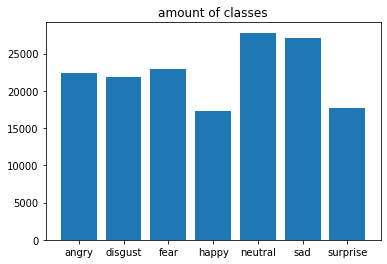

In [ ]:
number_of_amount = []
labels = []
for _, label in num2class.items():
    num = len(os.listdir(f'train_augmented/{label}'))
    number_of_amount.append(num)
    labels.append(label)
plt.title('amount of classes')
plt.bar(labels, number_of_amount)
plt.show()

In [ ]:
train_dataset = ImageFolder('/content/train_augmented', transform=image_to_tensor, target_transform=None)
valid_dataset = ImageFolder('/content/valid_augmented', transform=image_to_tensor, target_transform=None)
print(train_dataset)
print(valid_dataset)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_dataset, shuffle=True, batch_size=batch_size)

Dataset ImageFolder
    Number of datapoints: 157155
    Root location: /content/train_augmented
    StandardTransform
Transform: <function image_to_tensor at 0x7f162fe7a0e0>
Dataset ImageFolder
    Number of datapoints: 5744
    Root location: /content/valid_augmented
    StandardTransform
Transform: <function image_to_tensor at 0x7f162fe7a0e0>


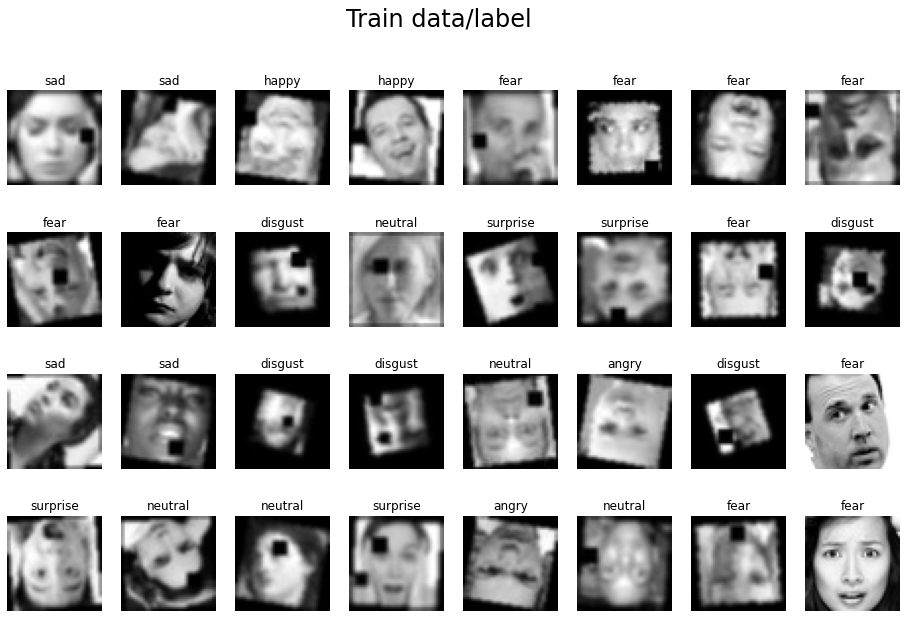

In [ ]:
plt.figure(figsize=(16, 10))
plt.suptitle("Train data/label", fontsize=24)
images, labels = next(iter(train_loader))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    image = images[i]
    label = labels[i].numpy().item()
    plt.title(num2class[label])
    image = unnormalize(image)
    plt.imshow(image.squeeze(0).numpy(), 'gray')
    plt.axis("off")
plt.show()

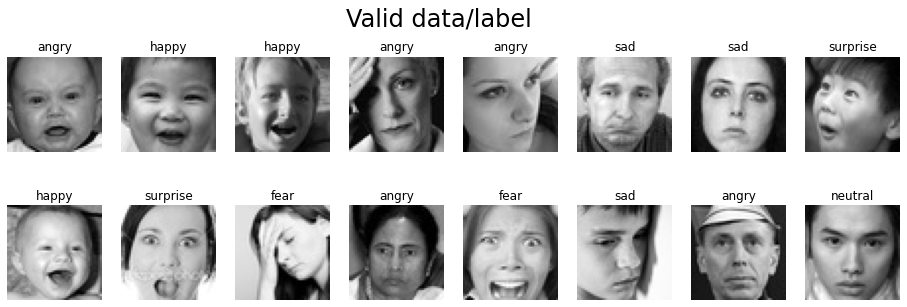

In [ ]:
plt.figure(figsize=(16, 5))
plt.suptitle("Valid data/label", fontsize=24)
images, labels = next(iter(valid_loader))
for i in range(16):
    plt.subplot(2, 8, i + 1)
    image = images[i]
    label = labels[i].numpy().item()
    plt.title(num2class[label])
    image = unnormalize(image)
    plt.imshow(image.squeeze(0).numpy(), 'gray')
    plt.axis("off")
plt.show()

In [ ]:
class VGG(nn.Module):
    def __init__(self, base_model, n_classes):
        super(VGG, self).__init__()

        self.input_conv = nn.Conv2d(1, 3, 3, 1, 1)
        self.featrue_extractor = base_model
        
        self.pooling = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )
        self.cls = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(32, 7),
        )
    def forward(self, input):
        x = self.input_conv(input)
        x = self.featrue_extractor(x)
        x = self.pooling(x)
        out = self.cls(x)
        return out

In [ ]:
from torchsummary import summary
device = 'cuda' if torch.cuda.is_available() else 'cpu'
base_model = vgg19_bn(weights=VGG19_BN_Weights.IMAGENET1K_V1).features
model = VGG(base_model, n_classes).to(device)
print(model)
summary(model, (1, 48, 48))

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (input_conv): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (featrue_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(k

In [ ]:
import gc
device = 'cuda' if torch.cuda.is_available() else 'cpu'

gc.collect()
torch.cuda.empty_cache()

base_model = vgg19_bn(weights=VGG19_BN_Weights.IMAGENET1K_V1).features
model = VGG(base_model, n_classes).to(device)

optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

best_val_loss = np.inf
start_time = time.time()

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    train_acc = 0
    for batch_idx, (imgs, labels) in enumerate(train_loader):
        imgs = imgs.type(torch.FloatTensor)
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(imgs)
            
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() 
        train_acc += torch.sum(preds == labels.data) / outputs.shape[0]

    train_epoch_loss = train_loss / len(train_loader)
    train_epoch_acc = train_acc / len(train_loader)

    train_losses.append(train_epoch_loss)
    train_accs.append(train_epoch_acc)

    with torch.no_grad():
        val_loss = 0
        val_acc = 0
        model.eval()
        for val_idx, (val_imgs, val_labels) in enumerate(valid_loader):
            val_imgs, val_labels = val_imgs.to(device), val_labels.to(device)

            with torch.cuda.amp.autocast():
                val_outputs = model(val_imgs)
            _, val_preds = torch.max(val_outputs, 1)
            loss = criterion(val_outputs, val_labels)

            val_loss += loss.item()
            val_acc += torch.sum(val_preds == val_labels.data) / val_outputs.shape[0]

        val_epoch_loss = val_loss / len(valid_loader)
        val_epoch_acc = val_acc / len(valid_loader)

        val_losses.append(val_epoch_loss)
        val_accs.append(val_epoch_acc)

        end_time = time.time() - start_time
        print(f'[Epoch {epoch}/{epochs}] [elapsed time: {end_time}]')
        print(f'[Train Loss: {train_epoch_loss}] [Train Accuracy: {train_epoch_acc}]')
        print(f'[Validation Loss: {val_epoch_loss}] [Validation Accuracy: {val_epoch_acc}]')
        print()

[Epoch 1/10] [elapsed time: 173.6684148311615]
[Train Loss: 1.615451477249593] [Train Accuracy: 0.38123881816864014]
[Validation Loss: 1.412109375] [Validation Accuracy: 0.5094494223594666]
Early Stop Count: 0
[Epoch 2/10] [elapsed time: 345.1386044025421]
[Train Loss: 1.3316900893220684] [Train Accuracy: 0.5227128863334656]
[Validation Loss: 1.1893012152777778] [Validation Accuracy: 0.5795139074325562]
Early Stop Count: 0
[Epoch 3/10] [elapsed time: 516.407069683075]
[Train Loss: 1.1591598063416124] [Train Accuracy: 0.6007451415061951]
[Validation Loss: 1.08896484375] [Validation Accuracy: 0.6065724492073059]
Early Stop Count: 0
[Epoch 4/10] [elapsed time: 687.7405385971069]
[Train Loss: 0.9983542377086726] [Train Accuracy: 0.6690778732299805]
[Validation Loss: 1.0449110243055555] [Validation Accuracy: 0.6296626925468445]
Early Stop Count: 0
[Epoch 5/10] [elapsed time: 860.6010038852692]
[Train Loss: 0.8407022184191775] [Train Accuracy: 0.737610399723053]
[Validation Loss: 1.124164496

In [ ]:
path = f'save_models/best_model.pth'
torch.save(model.state_dict(), path)

In [ ]:
PATH = '/content/save_models/best_model.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
base_model = vgg19_bn(weights=VGG19_BN_Weights.IMAGENET1K_V1).features
emotion_model = VGG(base_model, n_classes=7)
# print(emotion_model)
# checkpoint = torch.load(PATH, map_location=device)
# print(checkpoint.keys())
emotion_model.load_state_dict(torch.load(PATH, map_location=device))
emotion_model.to(device)

VGG(
  (input_conv): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (featrue_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(k

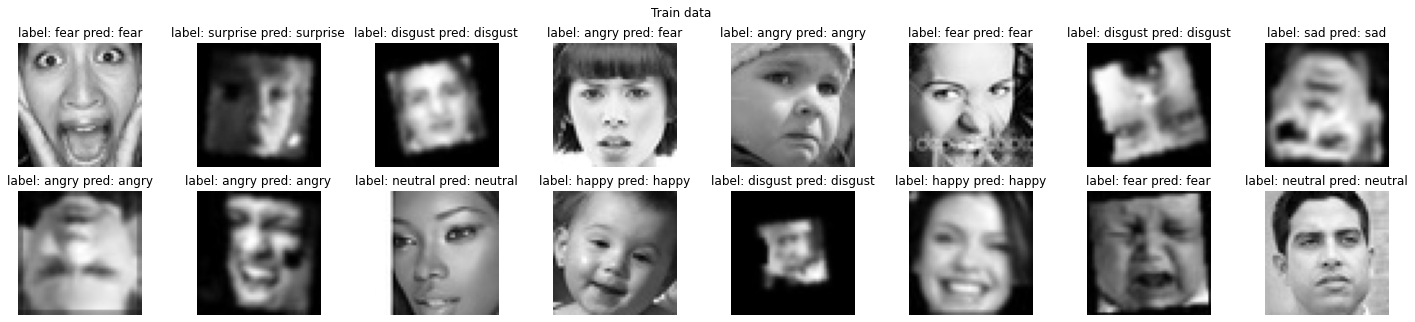

In [ ]:
images, labels = next(iter(train_loader))
images = images.to(device)
outputs = emotion_model(images)
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(25, 5))
plt.suptitle('Train data')
for i in range(16):
    plt.subplot(2, 8, i + 1)
    image = images[i]
    pred = preds[i].detach().cpu().numpy().item()
    label = labels[i].detach().cpu().numpy().item()
    plt.title(f'label: {num2class[label]} pred: {num2class[pred]}')
    image = unnormalize(image)
    plt.imshow(image.squeeze(0).detach().cpu().numpy(), 'gray')
    plt.axis("off")
plt.show()

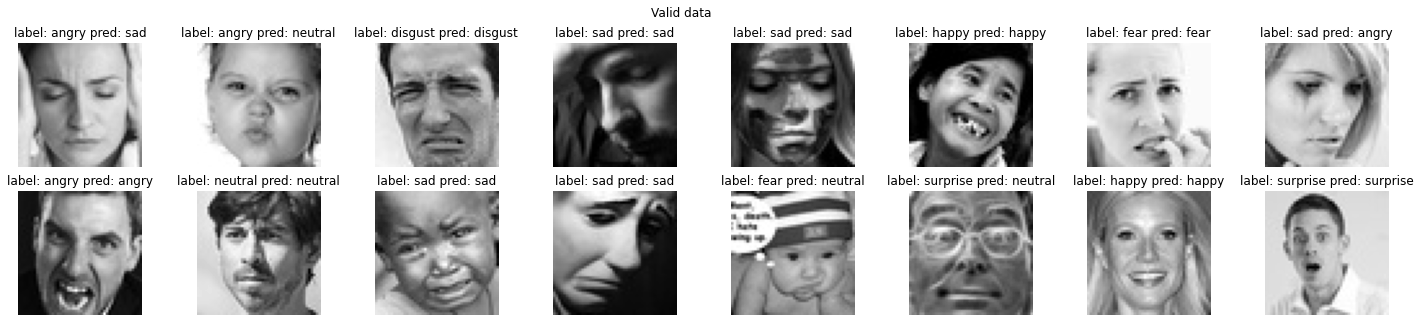

In [ ]:
images, labels = next(iter(valid_loader))
images = images.to(device)
outputs = emotion_model(images)
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(25, 5))
plt.suptitle('Valid data')
for i in range(16):
    plt.subplot(2, 8, i + 1)
    image = images[i]
    pred = preds[i].detach().cpu().numpy().item()
    label = labels[i].detach().cpu().numpy().item()
    plt.title(f'label: {num2class[label]} pred: {num2class[pred]}')
    image = unnormalize(image)
    plt.imshow(image.squeeze(0).detach().cpu().numpy(), 'gray')
    plt.axis("off")
plt.show()